<a href="https://colab.research.google.com/github/HB5101/CapsNet_Project/blob/master/Caps_Net(Num_r%3D2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is Keras implementation of CapsNet as per Geoffrey Hinton's paper Dynamic Routing Between Capsules using 2 routing iterations.


In [0]:
import tensorflow as tf
from tensorflow import keras
from keras import layers,Sequential
import keras.backend as K
from keras import layers, Model, initializers
from keras.layers import Input,Conv2D,Concatenate,Lambda,Reshape,Dense,Flatten,Reshape

In [0]:
from layers_capsnet_py import *
from datapreprocess import *

In [0]:
class Length(layers.Layer):
    """
     To compute the length of input vectors. 
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]


In [0]:
class Mask(layers.Layer):
   
    def call(self, inputs, **kwargs):
        if ((type(inputs) is list) and (len(inputs)==2)):  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules,mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked =(inputs * K.expand_dims(mask, -1))
        return masked


In [0]:
def CapsNet(input_shape, routings, n_class):

    x= layers.Input(shape=input_shape)    #inputNode

    y = layers.Input(shape=(n_class,))
    
    conv_layer = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv_layer')(x) #ReluConv1
    
    primary_layer= PrimaryCap( conv_layer, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')
    
    digitcapsule=DigiCap(num_capsule=n_class, dim_capsule=16, routings=routings, name='digitcapsule')(primary_layer)

    # The length of the capsule's output vector 
    encoder = Length(name="encoder")(digitcapsule)

    # masking
    masky = Mask()([digitcapsule, y])  
    maskeval = Mask()(digitcapsule)
    maskedy=Flatten()(masky)
    masked=Flatten()(maskeval)

    #decoder
    decoder =Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(784, activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape))
    
    # two-input-two-output keras Model

    #train_model
    train_model=Model([x, y], [encoder, decoder(maskedy)])

    #evalute_model
    eval_model=Model(x, [encoder, decoder(masked)])
   
    
    return train_model,eval_model
   

In [0]:
train,evalm=CapsNet(input_shape=x_test.shape[1:],routings=2,n_class=10)

In [0]:
train.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv_layer (Conv2D)             (None, 20, 20, 256)  20992       input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 6, 6, 8)      165896      conv_layer[0][0]                 
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 6, 6, 8)      165896      conv_layer[0][0]                 
__________________________________________________________________________________________________
conv2d_35 

In [0]:
evalm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv_layer (Conv2D)             (None, 20, 20, 256)  20992       input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 6, 6, 8)      165896      conv_layer[0][0]                 
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 6, 6, 8)      165896      conv_layer[0][0]                 
__________________________________________________________________________________________________
conv2d_35 

In [0]:
#encoder_loss
def margin_loss(y_true, y_pred):
  m_plus=0.9
  m_minus=0.1

  L = y_true * K.square(K.maximum(0., m_plus - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - m_minus))
  
  total=K.sum(L,axis=1)
  mean=K.mean(total)

  return mean


In [0]:
#decoder_loss
def MSE(y_true, y_pred):
  mse=tf.keras.losses.MeanSquaredError()
  return (0.0005)*mse(y_true, y_pred)


In [0]:
train.compile(optimizer="adam",loss=[margin_loss,MSE],metrics=["accuracy"])

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, LearningRateScheduler

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os

In [0]:
# Include the epoch in the file name (uses `str.format`)

checkpoint_path = '/content/drive/My Drive/CapsNet Project/CPnum2.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

csv_path ='/content/drive/My Drive/CapsNet Project/CPcsvNum2 - Sheet1.csv'

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True,period=1)
csv_callback = CSVLogger(csv_path, separator=",", append=True)

In [0]:
pip install tensorboardcolab

In [0]:
from tensorboardcolab import *

In [0]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://5b49f116.ngrok.io


In [0]:
#es_callback=EarlyStopping(patience=10, restore_best_weights=True)
#lr_callback= ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,min_lr=0.001)
def scheduler(epoch,lr):
  return float(lr * np.math.exp(-0.1))

lr_callback = LearningRateScheduler(scheduler)



In [0]:
train.fit([x_train,y_train],[y_train,x_train],batch_size=128, epochs=50, validation_data=[[x_test, y_test],[y_test, x_test]], callbacks=[cp_callback, csv_callback, lr_callback, TensorBoardColabCallback(tbc)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples







Epoch 1/50
60000/60000 [==============================] - 269s 4ms/step - loss: 0.2341 - encoder_loss: 0.2340 - decoder_loss: 7.1018e-05 - encoder_acc: 0.7477 - decoder_acc: 0.7870 - val_loss: 0.0245 - val_encoder_loss: 0.0245 - val_decoder_loss: 3.3645e-05 - val_encoder_acc: 0.9841 - val_decoder_acc: 0.8036

Epoch 00001: saving model to /content/drive/My Drive/CapsNet Project/CPnum2.h5

Epoch 2/50
60000/60000 [==============================] - 261s 4ms/step - loss: 0.0222 - encoder_loss: 0.0222 - decoder_loss: 3.3105e-05 - encoder_acc: 0.9855 - decoder_acc: 0.8043 - val_loss: 0.0175 - val_encoder_loss: 0.0175 - val_decoder_loss: 3.2769e-05 - val_encoder_acc: 0.9869 - val_decoder_acc: 0.8030

Epoch 00002: saving model to /content/drive/My Drive/CapsNet Project/CPnum2.h5
Epoch 3/50
60000/60000 [==============================] - 261s 4m

In [0]:
 y_pred, x_recon = evalm.predict(x_test, batch_size=100)

In [0]:

############ RESULTS

In [0]:
pred=np.zeros((10000,1))

In [0]:
for i in range(len(y_pred)):
  pred[i]=np.argmax(y_pred[i])

In [0]:
from sklearn.metrics import confusion_matrix, classification_report

In [0]:
#test_classification_accuracy
print(classification_report(np.argmax(y_test, axis = 1), pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [0]:
from random import randint 

In [0]:
random=[]
for _ in range(9):
	value = randint(0, len(x_test))
	random.append(value)

original


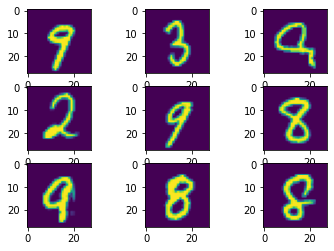

reconstructed


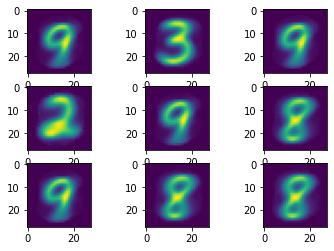

In [0]:
#test_image_reconstuction
from matplotlib import pyplot
# load dataset

# summarize loaded dataset
# plot first few images
print("original")
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(Xt_test_img[random[i]])
# show the figure
pyplot.show()
print("reconstructed")
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
 
	pyplot.imshow(x_recon[random[i]].reshape(28,28))
# show the figure
pyplot.show()
